In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
from torchvision import transforms
import pandas as pd
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [36]:
def hist_train_data(d_values, fractal_types, bins=20):

    data = pd.DataFrame({
        'd_value': d_values,
        'fractal_type': fractal_types
    })

    unique_types = data['fractal_type'].unique()
    plt.figure(figsize=(10, 6))

    for ftype in unique_types:
        subset = data[data['fractal_type'] == ftype]
        plt.hist(subset['d_value'], bins=bins, alpha=0.5, label=str(ftype), edgecolor='black')

    plt.title('Histogram of D-values Used in Training by Fractal Type')
    plt.xlabel('D-value')
    plt.ylabel('Frequency')
    plt.legend(title='Fractal Type')
    plt.grid(True)
    plt.show()

def scatter_test_error(true_values, errors, fractal_types):

    unique_types = np.unique(fractal_types)
    colors = plt.cm.tab10.colors  # A colormap with enough distinct colors

    plt.figure(figsize=(10, 6))

    for idx, ftype in enumerate(unique_types):
        # Select data corresponding to the current fractal type
        indices = fractal_types == ftype
        plt.scatter(
            true_values[indices],
            errors[indices],
            color=colors[idx % len(colors)],
            alpha=0.6,
            label=str(ftype)
        )

    plt.title('Error as a Function of D Value by Fractal Type')
    plt.xlabel('True D Value')
    plt.ylabel('Absolute Error')
    plt.legend(title='Fractal Type')
    plt.grid(True)
    plt.show()

def hist_test_error_type(errors, fractal_types, bins = 20):

    plt.figure(figsize=(10, 6))
    unique_types = np.unique(fractal_types)
    colors = plt.cm.tab10.colors 

    # Define the number of bins for the histogram':

    for idx, ftype in enumerate(unique_types):
        indices = fractal_types == ftype
        plt.hist(
            errors[indices],
            bins=bins,
            alpha=0.5,
            color=colors[idx % len(colors)],
            label=str(ftype),
            edgecolor='black'
        )
        
    plt.title('Histogram of Prediction Errors by Fractal Type')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend(title='Fractal Type')
    plt.grid(True)
    plt.show()

def hist_test_error_D(true_values, errors, d_bins = None):   

    if d_bins == None:
        d_bins = np.linspace(true_values.min(), true_values.max(), num=5)
        d_bin_indices = np.digitize(true_values, bins=d_bins)  
    else:
        d_bins = d_bins
        d_bin_indices = np.digitize(true_values, bins=d_bins)

    plt.figure(figsize=(10, 6))

    for idx in range(1, len(d_bins)):
        indices = d_bin_indices == idx
        plt.hist(
            errors[indices],
            bins=20,
            alpha=0.5,
            label=f'D in [{d_bins[idx-1]:.2f}, {d_bins[idx]:.2f}]',
            edgecolor='black',
            stacked=True
        )

    plt.title('Histogram of Prediction Errors by D Value Ranges')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend(title='D Value Range')
    plt.grid(True)
    plt.show()



In [27]:
class FractalDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # Convert to grayscale if needed
        d_value = torch.tensor(self.labels.iloc[idx, 1], dtype=torch.float32)
        fractal_type = self.labels.iloc[idx, 2]    # Assuming fractal type is in the third column

        if self.transform:
            image = self.transform(image)

        return image, d_value, fractal_type


class FractalCNN(nn.Module):
    def __init__(self):
        super(FractalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = None
        self.fc2 = nn.Linear(256, 1)

    def _initialize_fc(self, x):
        x = self.convs(x)
        flattened_size = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(flattened_size, 256).to(x.device)  # Ensure fc1 is on the same device

    def convs(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x)
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_values = []     # List to store loss values
    used_d_values = []   # List to store d-values used in training
    used_fractal_types = []  # List to store fractal types

    model.to(device)     # Move the model to the GPU

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()    # Set the model to training mode

        for images, labels, fractal_types in train_loader:
            images = images.to(device)            # Move images to the GPU
            labels = labels.to(device).unsqueeze(1)  # Move labels to the GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Collect the labels and fractal types
            used_d_values.extend(labels.cpu().numpy().flatten())
            used_fractal_types.extend(fractal_types)

        avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
        loss_values.append(avg_loss)               # Store the average loss

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Plot the loss function after training
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Plot the histogram of used d-values
    hist_train_data(used_d_values, used_fractal_types)

In [30]:
def create_balanced_train_loader(
    image_dir,
    labels_dir,
    transform,
    d_ranges,
    total_samples,
    batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
):
    """
    Creates a DataLoader with a balanced distribution of D values.

    Parameters:
    - image_dir (str): Path to the directory containing images.
    - labels_dir (str): Path to the CSV file containing labels.
    - transform (torchvision.transforms): Transformations to apply to the images.
    - d_ranges (list of dict): List of dictionaries specifying D value ranges and target proportions.
    - total_samples (int): Total number of samples to include in the DataLoader.
    - batch_size (int): Number of samples per batch to load.
    - shuffle (bool): Whether to shuffle the data.
    - num_workers (int): Number of subprocesses to use for data loading.
    - pin_memory (bool): Whether to pin memory during data loading.

    Returns:
    - train_loader (DataLoader): DataLoader with the balanced dataset.
    """
    # Read the labels CSV into a DataFrame
    labels_df = pd.read_csv(labels_dir)

    # Calculate number of samples per range
    for d_range in d_ranges:
        d_range['n_samples'] = int(total_samples * d_range['proportion'])

    sampled_indices = []

    for d_range in d_ranges:
        # Filter the DataFrame for the current D value range
        range_df = labels_df[
            (labels_df['d_value'] >= d_range['min']) &
            (labels_df['d_value'] < d_range['max'])
        ]

        # Check if enough samples are available
        available_samples = len(range_df)
        required_samples = d_range['n_samples']

        if available_samples < required_samples:
            print(f"Not enough samples in range {d_range['min']} - {d_range['max']}. Using all available samples ({available_samples}).")
            required_samples = available_samples

        # Randomly sample the required number of indices
        sampled_range_df = range_df.sample(n=required_samples, random_state=42)
        sampled_indices.extend(sampled_range_df.index.tolist())

    # Create a FractalDataset instance
    train_dataset = FractalDataset(
        image_dir=image_dir,
        label_file=labels_dir,
        transform=transform
    )

    # Create a Subset of the Dataset
    sampled_subset = Subset(train_dataset, sampled_indices)

    # Create the DataLoader
    train_loader = DataLoader(
        sampled_subset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_loader

Not enough samples in range 1.7 - 1.9. Using all available samples (138).
Epoch [1/10], Loss: 0.5711
Epoch [2/10], Loss: 0.0622
Epoch [3/10], Loss: 0.0268
Epoch [4/10], Loss: 0.0088
Epoch [5/10], Loss: 0.0056
Epoch [6/10], Loss: 0.0050
Epoch [7/10], Loss: 0.0043
Epoch [8/10], Loss: 0.0039
Epoch [9/10], Loss: 0.0035
Epoch [10/10], Loss: 0.0031


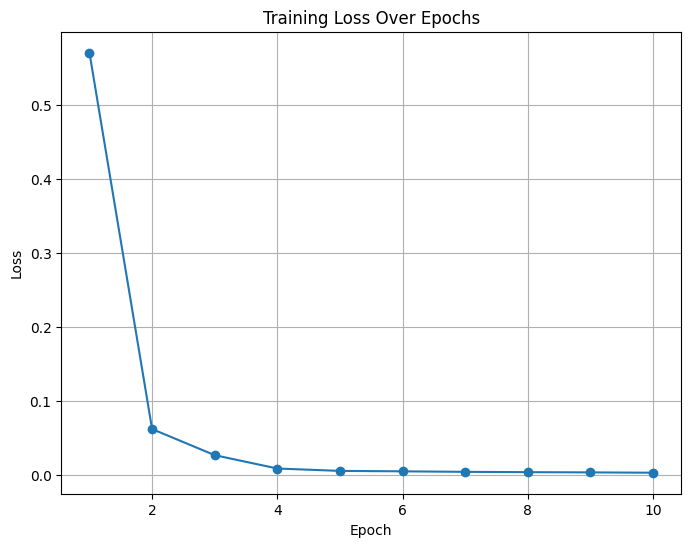

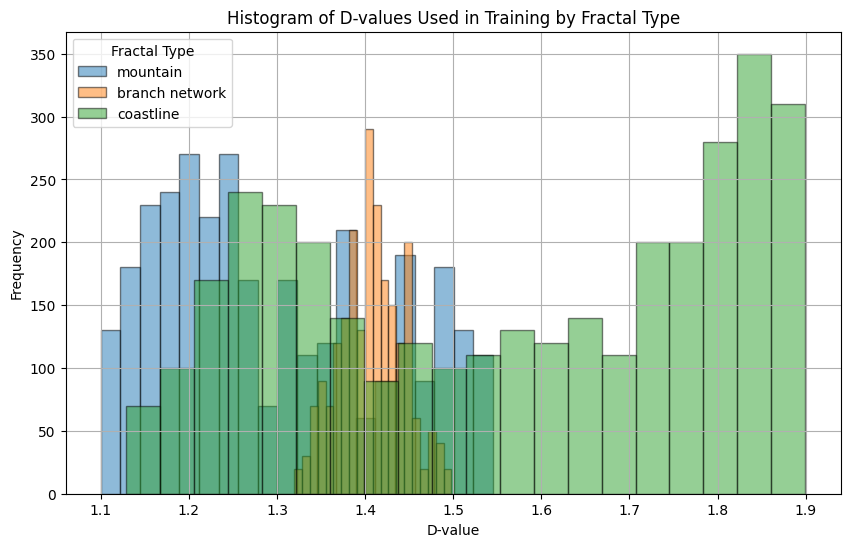

In [31]:
image_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch'
labels_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch/labels.csv'

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),          # Convert PIL images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

d_ranges = [
    {'min': 1.1, 'max': 1.3, 'proportion': 0.25},
    {'min': 1.3, 'max': 1.7, 'proportion': 0.50},
    {'min': 1.7, 'max': 1.9, 'proportion': 0.25}
]

total_samples = 1000
batch_size = 50
shuffle = True
num_workers = 4
pin_memory = True

train_loader = create_balanced_train_loader(
    image_dir=image_dir,
    labels_dir=labels_dir,
    transform=transform,
    d_ranges=d_ranges,
    total_samples=total_samples,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    pin_memory=pin_memory
)


train_dataset = FractalDataset(image_dir=image_dir, label_file=labels_dir, transform=transform)
#train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4, pin_memory=True)

model = FractalCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Average Test Loss: 0.0033
Average Deviation (MAE): 0.0453


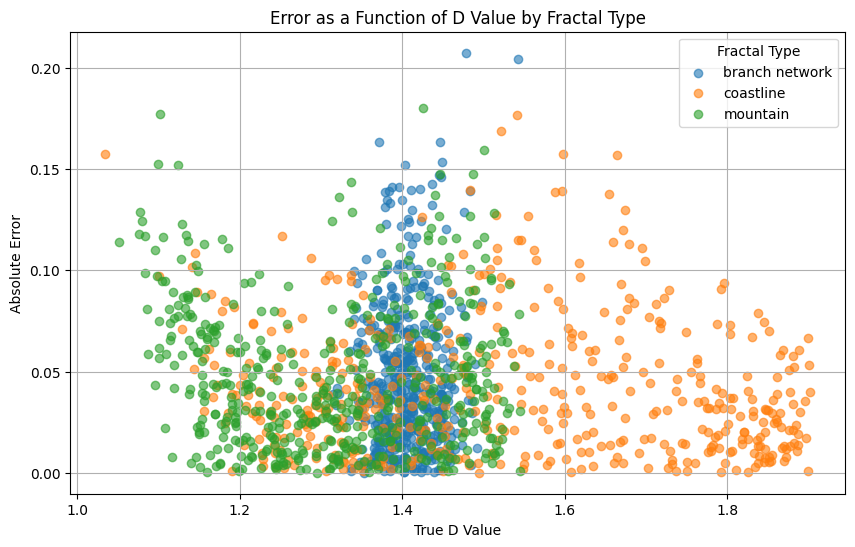

In [32]:
test_image_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch'
test_labels_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch/labels.csv'

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure consistent resizing
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Ensure consistent normalization
])

# Prepare the test dataset and DataLoader
test_dataset = FractalDataset(image_dir=test_image_dir, label_file=test_labels_dir, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,         
    pin_memory=True        
)

# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_loss = 0.0
criterion = nn.MSELoss()
predictions = []
true_values = []
fractal_types = []  # To store fractal types

# Disable gradient computation for testing
with torch.no_grad():
    for images, labels, types in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        labels = labels.view(-1, 1)

        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predictions.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())
        fractal_types.extend(types)  


predictions = np.array(predictions).flatten()
true_values = np.array(true_values).flatten()
fractal_types = np.array(fractal_types)  

errors = np.abs(predictions - true_values)
mae = np.mean(errors)

test_loss /= len(test_loader)

print(f'Average Test Loss: {test_loss:.4f}')
print(f'Average Deviation (MAE): {mae:.4f}')

scatter_test_error(true_values, errors, fractal_types)

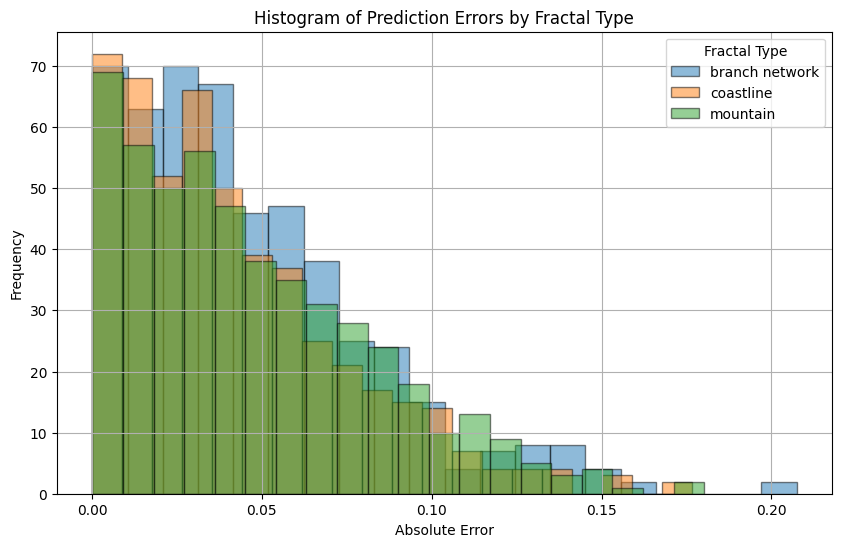

In [37]:
hist_test_error_type(errors, fractal_types)

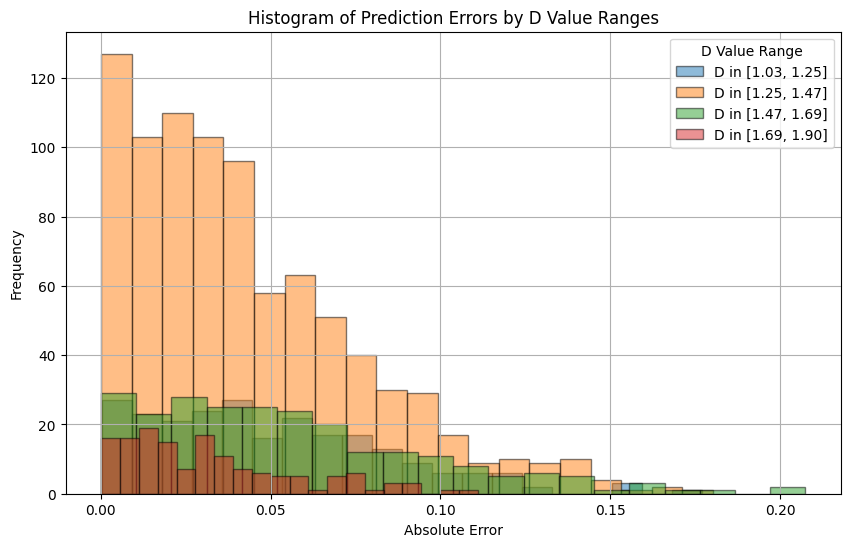

In [38]:
hist_test_error_D(true_values, errors)

things to do :::::::


Hist data D values going into model: YUP

hist test data used for evalutation: YUP

^^^^ For these make them stack vertically not horizontally (on top not see through)

find way to force proportions of D values for training data

moer fractal types

actually learn the art of ML
?????

profit